In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Github/PAC

/content/drive/MyDrive/Github/PAC


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from src import data
from src.segmentation import UNet
from src import metrics, measure
from src.config import Paths

plt.style.use('reports/report.mplstyle')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['navy', 'cornflowerblue', 'blueviolet', 'r'])
plt.rcParams['figure.figsize'] = (5, 3)

In [ ]:
models = []
for filepath in Paths.models.glob('unet*'):
    if filepath.is_dir():

        logs = UNet(filepath.stem).get_logs()
        best_epoch, min_val_area_mape = logs.loc[np.argmin(logs.val_area_mape)].loc[['epoch', 'val_area_mape']]

        configs = filepath.stem.split('-')
        models.append({
            'path': filepath,
            'stem': filepath.stem,
            'loss': configs[1],
            'filters': configs[2],
            'best_epoch': best_epoch + 1,
            'min_val_area_mape': min_val_area_mape
        })
models = pd.DataFrame(models)
models

,path,stem,loss,filters,best_epoch,min_val_area_mape
0,models/unet-binary_crossentropy-16_32_64-ii,unet-binary_crossentropy-16_32_64-ii,binary_crossentropy,16_32_64,480.0,0.418916
1,models/unet-binary_crossentropy-16_32_64,unet-binary_crossentropy-16_32_64,binary_crossentropy,16_32_64,88.0,1.587345


In [ ]:
def loss_by_name(name):
    loss = None
    try:
        loss = getattr(metrics, name)
    except:
        try: loss = getattr(tf.keras.losses, name)
        except: raise Exception(f'Função {name} não encontrada em tf.keras.losses ou em src.metrics')
    return loss

def get_metrics(model_name):
    logs = UNet(model_name).get_logs()
    my_metrics = []
    for col in logs.columns:
        if col not in ('epoch', 'loss') and 'val' not in col:
            try: my_metrics.append(getattr(metrics, col))
            except:
                try: my_metrics.append(getattr(tf.keras.metrics, col))
                except: raise Exception(f'Função {col} não encontrada em tf.keras.losses ou em src.metrics')
    return my_metrics

In [ ]:
dataset = (x_train, y_train), (x_test, y_test) = data.load_dataset(augmentation=True, grayscale=True, norm=True)

In [ ]:
best_model_info = models.loc[np.argmin(models.min_val_area_mape)]
best_model = UNet(best_model_info.stem, dataset).load(compile=False)
best_model.load_weights(int(best_model_info.best_epoch))
best_model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss= loss_by_name(best_model_info.loss),
    metrics= get_metrics(best_model_info.stem)
)

In [ ]:
best_model.evaluate()

2/2 [==============================] - 12s 4s/step - loss: 0.0169 - DSC: 0.9957 - IoU: 0.9914 - area_mape: 0.4171


[0.0169413760304451, 0.995664656162262, 0.9913729429244995, 0.417097806930542]

In [ ]:
best_model_info.best_epoch

480.0

In [ ]:
from src.visualize import plot_image
from google.colab import files

def fig_download(fig, filename, **kw):
    default = dict(bbox_inches='tight', format='svg', pad_inches=0)
    kw_keys = list(kw.keys())
    for k, v in default.items():
        if not k in kw_keys: kw[k] = v
    fig.savefig(filename, **kw)
    files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

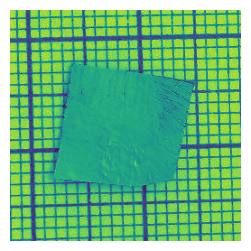

In [ ]:
plot_image(x_test[2])
# fig_download(plt.gcf(), 'sample.svg')

1/1 [==============================] - 0s 432ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

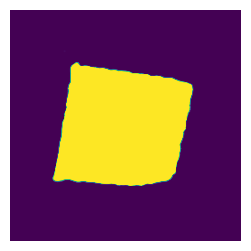

In [ ]:
plot_image(best_model.predict(x_test[2][np.newaxis]))
# fig_download(plt.gcf(), 'unet_output.svg')

In [ ]:
logs = best_model.get_logs()
logs

,epoch,DSC,IoU,area_mape,loss,val_DSC,val_IoU,val_area_mape,val_loss
0,0,0.536540,0.370037,181.774979,0.695139,0.526302,0.357183,126.035744,0.644701
1,1,0.658651,0.495319,141.098907,0.455822,0.520466,0.351900,134.912720,0.655005
2,2,0.747587,0.598752,108.171944,0.315044,0.423024,0.268770,229.130341,0.911137
3,3,0.788813,0.652268,120.395020,0.254934,0.328146,0.198036,324.495911,1.478456
4,4,0.808857,0.679686,89.254318,0.224852,0.278464,0.164019,367.970673,2.190258
...,...,...,...,...,...,...,...,...,...
814,810,0.999496,0.998993,0.104096,0.000738,0.995332,0.990716,0.825183,0.029256
815,811,0.999501,0.999002,0.120506,0.000752,0.995405,0.990863,0.710793,0.028311
816,812,0.999557,0.999115,0.070544,0.000638,0.995572,0.991191,0.598491,0.026929
817,813,0.999582,0.999165,0.064915,0.000577,0.995481,0.991011,0.759251,0.028186


In [ ]:
logs[logs.epoch == 479]

,epoch,DSC,IoU,area_mape,loss,val_DSC,val_IoU,val_area_mape,val_loss
481,479,0.998651,0.997305,0.202388,0.00221,0.995662,0.991368,0.418916,0.016965


In [ ]:
import matplotlib.patches as patches

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

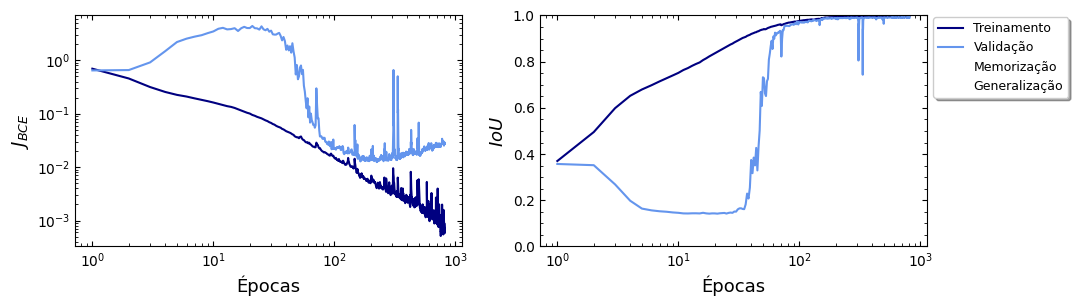

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))

axs[0].plot(logs.epoch + 1, logs.loss)
axs[0].plot(logs.epoch + 1, logs.val_loss, 'C1')
axs[0].semilogy()
axs[0].semilogx()
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel(r'$J_{BCE}$')

axs[1].plot(logs.epoch + 1, logs.IoU, label='Treinamento')
axs[1].plot(logs.epoch + 1, logs.val_IoU, 'C1', label='Validação')
# axs[1].vlines(best_model_info.best_epoch, *axs[1].get_ylim(), color='C3', linestyles='--', label='mínimo MAPE (área)')
axs[1].semilogx()
# axs[1].semilogy()
axs[1].set_ylim(0, 1)
axs[1].plot([], [], ' ', label='Memorização')
axs[1].plot([], [], ' ', label='Generalização')
legend = axs[1].legend(bbox_to_anchor=(1, 1.02))
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel(r'$IoU$')

fig_download(fig, 'treinamento.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

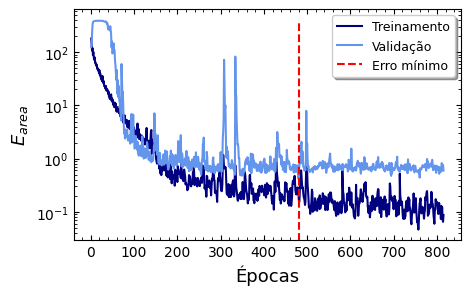

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(logs.epoch + 1, logs.area_mape, label='Treinamento')
plt.plot(logs.epoch + 1, logs.val_area_mape, 'C1', label='Validação')
plt.vlines(best_model_info.best_epoch, *plt.gca().get_ylim(), color='C3', linestyles='--', label=r'Erro mínimo')
plt.semilogy()
plt.legend()#bbox_to_anchor=(1.45, 1.02))
plt.xlabel('Épocas')
plt.ylabel(r'$E_{area}$')
fig_download(plt.gcf(), 'MAPE.svg')

In [ ]:
y_train_pred = best_model.predict(x_train)
y_test_pred = best_model.predict(x_test)

2/2 [==============================] - 9s 5s/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

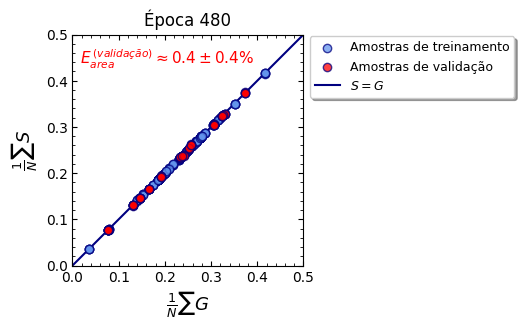

In [ ]:
WH = 256**2
plt.scatter(tf.reduce_sum(y_train, axis=(1, 2, 3))/WH, tf.reduce_sum(y_train_pred, axis=(1, 2, 3))/WH, color='C1', alpha=0.75, edgecolor='C0', label='Amostras de treinamento')
plt.scatter(tf.reduce_sum(y_test, axis=(1, 2, 3))/WH, tf.reduce_sum(y_test_pred, axis=(1, 2, 3))/WH, color='C3', alpha=0.75, edgecolor='C0', label='Amostras de validação')
t = np.linspace(0, 0.5, 50)
plt.plot(t, t, 'C0-', zorder=0, label=r'$S=G$')
plt.xlabel(r'$\frac{1}{N}\sum G$')
plt.ylabel(r'$\frac{1}{N}\sum S$')
plt.ylim(0, 0.5)
plt.xlim(0, 0.5)
plt.legend(bbox_to_anchor=(1, 1.02))
plt.text(0.017, 0.435, r'$E_{area}^{\,(validação)}\approx 0.4 \pm 0.4$%', fontsize=11, color='C3')
plt.gca().set_aspect('equal')
plt.title(f'Época {int(best_model_info.best_epoch)}')
fig_download(plt.gcf(), 'validação.svg')

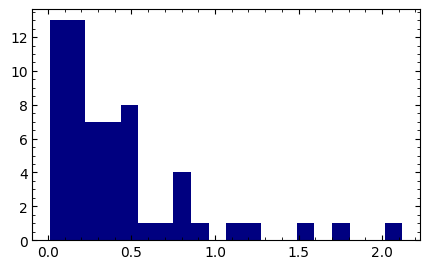

In [ ]:
# area_train = tf.reduce_sum(y_train, axis=(1, 2, 3))
# area_train_pred = tf.cast(tf.reduce_sum(y_train_pred, axis=(1, 2, 3)), tf.double)
# plt.hist(np.abs(area_train_pred - area_train)/area_train * 100, bins=50)
area_test = tf.reduce_sum(y_test, axis=(1, 2, 3))
area_test_pred = tf.cast(tf.reduce_sum(y_test_pred, axis=(1, 2, 3)), tf.double)
plt.hist(np.abs(area_test_pred - area_test)/area_test * 100, bins=20)
plt.show()

In [ ]:
jpg_files, png_files, areas = data.load_all('test/*', area=True)
jpg_files = data.flipping_augmentation(jpg_files)
png_files = data.flipping_augmentation(png_files)
areas = np.concatenate(np.repeat([areas], 4, axis=0))
jpg_files.shape, png_files.shape, areas.shape

(TensorShape([60, 256, 256, 1]), TensorShape([60, 256, 256, 1]), (60,))

In [ ]:
import src.visualize as vs

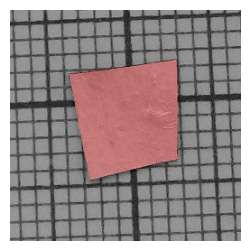

In [ ]:
best_model.namei = np.random.randint(len(areas))
vs.plot_label(jpg_files[i], png_files[i])

In [ ]:
scales = np.stack([measure.find_scale(im)[0] for im in jpg_files[..., 0]])
scales.shape

(60,)

In [ ]:
segs = best_model.predict(jpg_files)
segs.shape

2/2 [==============================] - 13s 4s/step


(60, 256, 256, 1)

In [ ]:
H = np.abs(areas - tf.reduce_sum(segs, axis=(1, 2, 3))*scales)/areas * 100
H.mean(), H.std()

(1.7528696270562738, 1.587366705015864)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model.model)
converter

In [ ]:
tflite_model = converter.convert()

In [ ]:
with open(Paths.models/'unet-0.41.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter

In [ ]:
output = interpreter.get_output_details()[0]  # Model has single output.
input = interpreter.get_input_details()[0]  # Model has single input.
interpreter.allocate_tensors()

In [ ]:
i = 3
interpreter.set_tensor(input['index'], tf.cast(tf.reshape(x_train[i], (1, *x_train[i].shape)), tf.float32))
interpreter.invoke()
out = interpreter.get_tensor(output['index'])
out.shape

(1, 256, 256, 1)

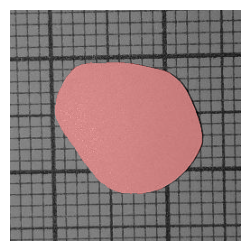

In [ ]:
vs.plot_label(x_train[i], out > 0.5)